In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_eul_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
# eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'symbolic',gen_matlab_functions = 1)
MM,FO,TE,TE_conoid,q,u,fr,frstar,kindeq,xdot,activations = eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
time_to_create = tm.time() - start
print(time_to_create)

TE created
equations created
482.3325357437134


In [3]:
import equations as eq
reload (eq);
data_struct = sc.io.loadmat('../data_model.mat')
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondEul'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 51
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_eul(file,num_nodes)

In [6]:
state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [7]:
def obj(free):
    min_traj = 200 * interval_value * np.sum((traj - free[:10*num_nodes])**2)
    min_vel = 5 * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = 1 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = 200 * 2.0 * interval_value * (free[:10*num_nodes] - traj)
    grad[10*num_nodes:num_states*num_nodes] = 5 * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 1 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [8]:
instance_constraints = []
for i in range(10):
    instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])

# instance_constraints.append(state_symbols[9].func(0.0)-x0t[9])
# instance_constraints.append(state_symbols[8].func(0.0)-x0t[8])
# instance_constraints.append(state_symbols[7].func(0.0)-x0t[7])
# instance_constraints.append(state_symbols[6].func(0.0)-x0t[6])

    

# # bounds = (-3,3)*len(w)
# # bndrs = dict(zip(w,bounds))
bounds1 = (0.0,1)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [9]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #    
time_to_create = tm.time() - start
print(time_to_create)


1137.6660652160645


In [10]:
# feas_tol = 1e-5
prob.add_option('max_iter',10000)
# prob.add_option('acceptable_tol', feas_tol)
# prob.add_option('tol', feas_tol)
# prob.add_option('constr_viol_tol', feas_tol)
# prob.add_option('bound_frac', 0.001)
# prob.add_option('mu_strategy', 'adaptive')
prob.add_option('limited_memory_max_history', 40)
# prob.add_option('acceptable_constr_viol_tol', feas_tol)
# prob.add_option('nlp_scaling_method', 'None')

In [11]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj

In [12]:
start = tm.time()
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])
time_to_create = tm.time() - start
print(time_to_create)

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
6.723064374694177
30.950684309005737


22.524063834594028


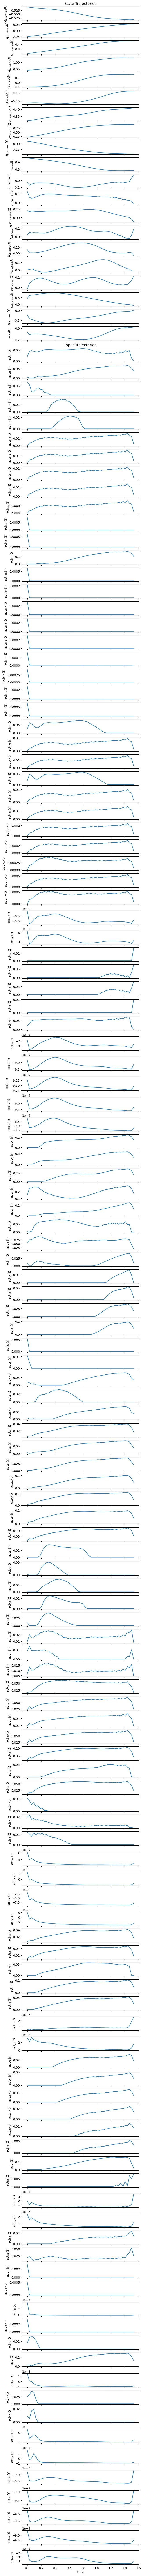

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print(act_obj)

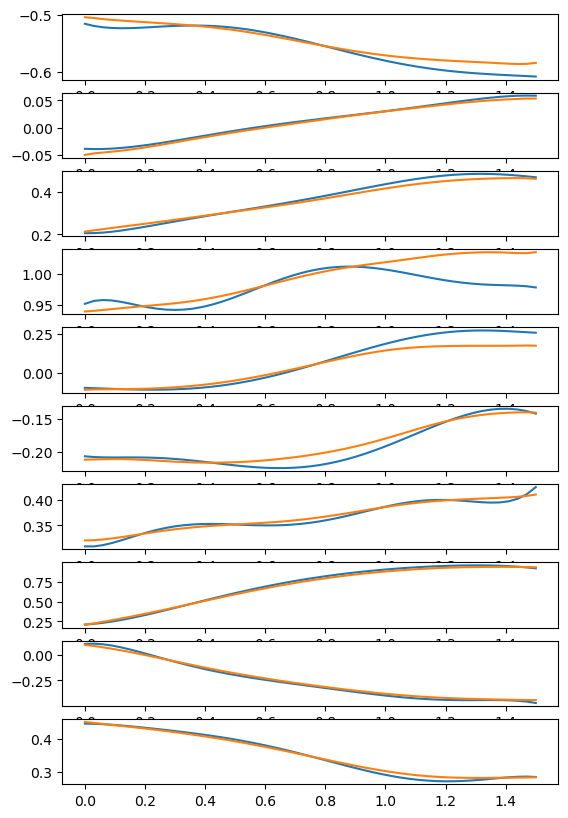

In [14]:
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

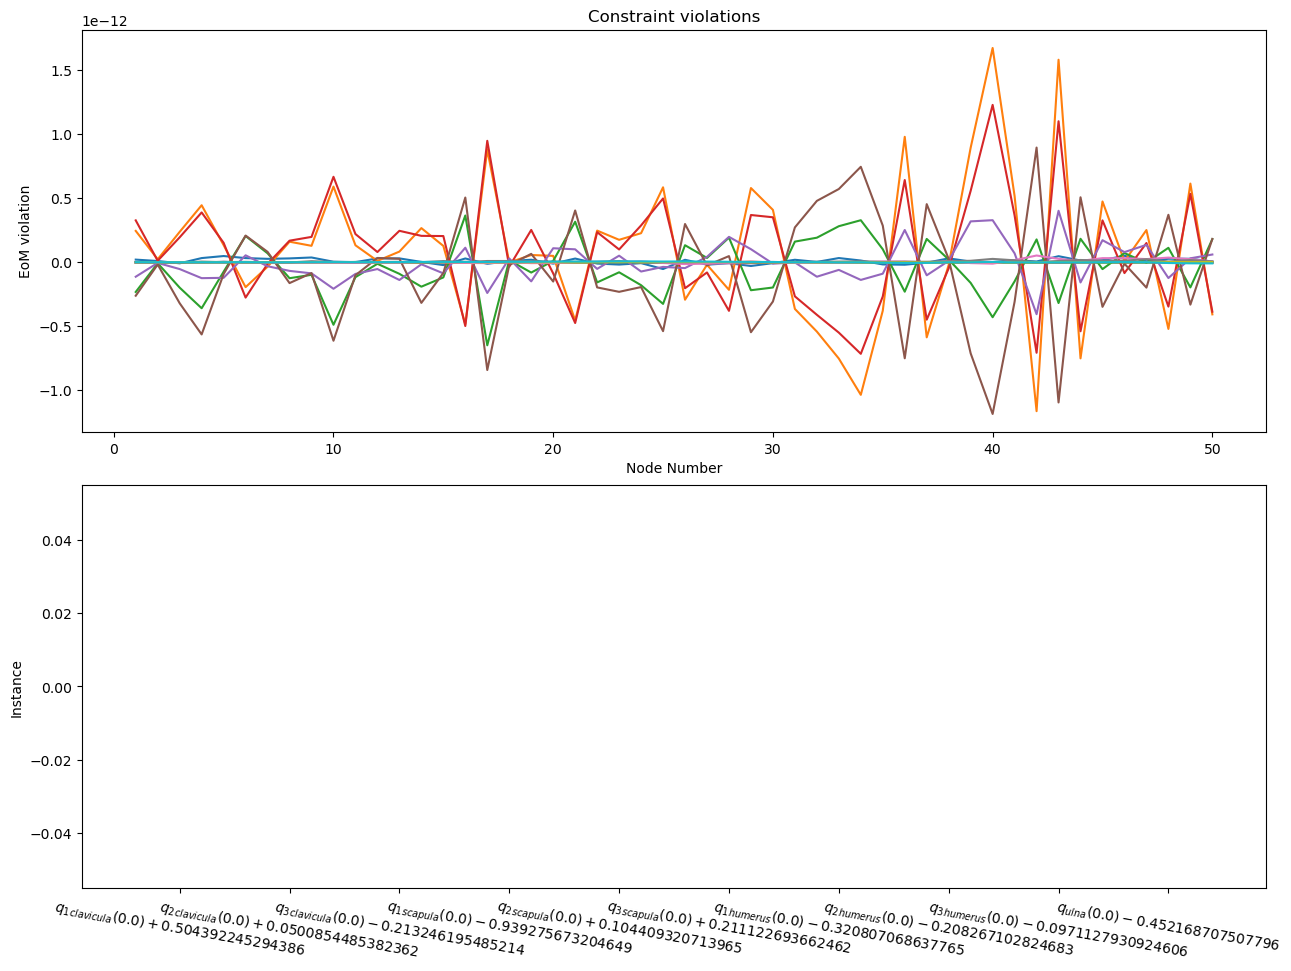

In [15]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)

In [16]:
# import equations as eq
# reload (eq);

# sol = eq.sol2mot_quat(solution, num_nodes, len(q), time)


In [17]:
# # import trajectory_lib as 
# reload (tr);
# file_name = '../eul_abd_eulIC.mat'
# tr.quat2matfile(solution,activations,len(q),num_states,num_nodes,time,file_name)